<a href="https://colab.research.google.com/github/kayserim/prj_id/blob/main/train_and_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TODO LIST


auc precision recall

LSTM+CNN

SMOTE

normalization

other features -> demographics diagnostics and more chartevents

5-FOLD CROSS VALIDATION

HYPER-PARAMETER TUNING 

ROC-AUC curve

CE-STATs for logistic regression


In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd '/content/drive/MyDrive/cse6250_proj' 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cse6250_proj


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

from utils import train, evaluate, load_dataset, plot_learning_curves
from mymodels import MyLR, MyLSTM

# Set a correct path to the seizure data file you downloaded
PATH_TRAIN_FILE = "./data/all/XY_train_LITE.csv"
PATH_VALID_FILE = "./data/all/XY_validation_LITE.csv"
PATH_TEST_FILE = "./data/all/XY_test_LITE.csv"

# TODO need to match hyperparameters to paper
MODEL_TYPE = 'LSTM' #LR, LSTM, LSTMCNN 
NUM_EPOCHS = 10
BATCH_SIZE = 32
USE_CUDA = True  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.

HOURS_LIMIT = 48


In [ ]:
# mostly taken from trainseizure.py
device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")
if device.type == "cuda":
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

num_features, train_dataset = load_dataset(PATH_TRAIN_FILE, MODEL_TYPE, HOURS_LIMIT)
_, valid_dataset = load_dataset(PATH_VALID_FILE, MODEL_TYPE, HOURS_LIMIT)
_, test_dataset = load_dataset(PATH_TEST_FILE, MODEL_TYPE, HOURS_LIMIT)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

if MODEL_TYPE == 'LR':
	model = MyLR(num_features)
elif MODEL_TYPE == 'LSTM':
	model = MyLSTM(num_features)
elif MODEL_TYPE == 'LSTMCNN':
	raise AssertionError("Model Type Not Implemented Yet!")
else:
	raise AssertionError("Wrong Model Type!")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

best_val_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

best_model = None
for epoch in range(NUM_EPOCHS):
	train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
	valid_loss, valid_accuracy, valid_results = evaluate(model, device, valid_loader, criterion)

	train_losses.append(train_loss)
	valid_losses.append(valid_loss)

	train_accuracies.append(train_accuracy)
	valid_accuracies.append(valid_accuracy)

	is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best:
		best_val_acc = valid_accuracy
		best_model= model


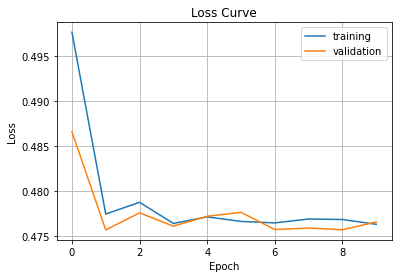

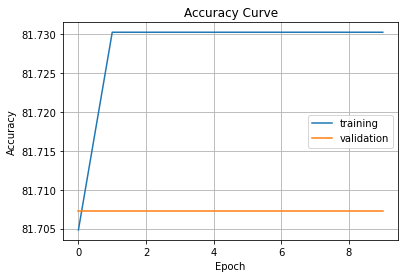

Test: [0/16]	Time 0.002 (0.002)	Loss 0.3335 (0.3335)	Accuracy 90.625 (90.625)
Test: [10/16]	Time 0.001 (0.001)	Loss 0.6345 (0.4703)	Accuracy 71.875 (82.102)


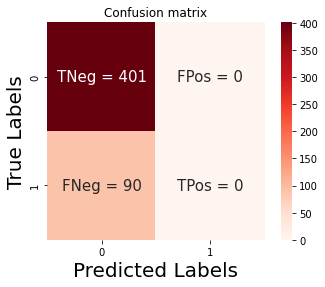

test accuracy is: 81.67006120856571


In [ ]:
plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)
test_loss, test_accuracy, test_results = evaluate(best_model, device, test_loader, criterion)
y_true, y_pred = zip(*test_results)   
cm=confusion_matrix(y_true, y_pred)
sns.heatmap(cm, square=True, cmap='Reds', xticklabels=['0', '1'], yticklabels=['0', '1'], annot=[['TNeg = {}'.format(cm[0][0]), 'FPos = {}'.format(cm[0][1])],
                                                                                                ['FNeg = {}'.format(cm[1][0]), 'TPos = {}'.format(cm[1][1])]], fmt="", annot_kws={"size": 15})
plt.ylabel('True Labels', fontsize=20);
plt.xlabel('Predicted Labels', fontsize=20);
plt.title("Confusion matrix")
plt.show()
print(f'test accuracy is: {test_accuracy}')

In [ ]:
# was hoping that this code will generate a nice visualization for the model but it is pretty complicated (see below) hence disabled the execution of the cell
#!pip install wandb -Uq
#
#import torch.onnx
#import wandb
#wandb.login()
#with wandb.init(project="test-demo", settings=wandb.Settings(symlink=False)) as run:
#  dummy_input, _ = next(iter(valid_loader))
#  torch.onnx.export(best_model, dummy_input.to(device), "model.onnx")
#  model_artifact = wandb.Artifact("test", type="model", description="test")
#  model_artifact.add_file("model.onnx")
#  run.log_artifact(model_artifact)

was hoping that above code will generate a nice visualization for the model but it is pretty complicated (see below) hence disabled the execution of the cell


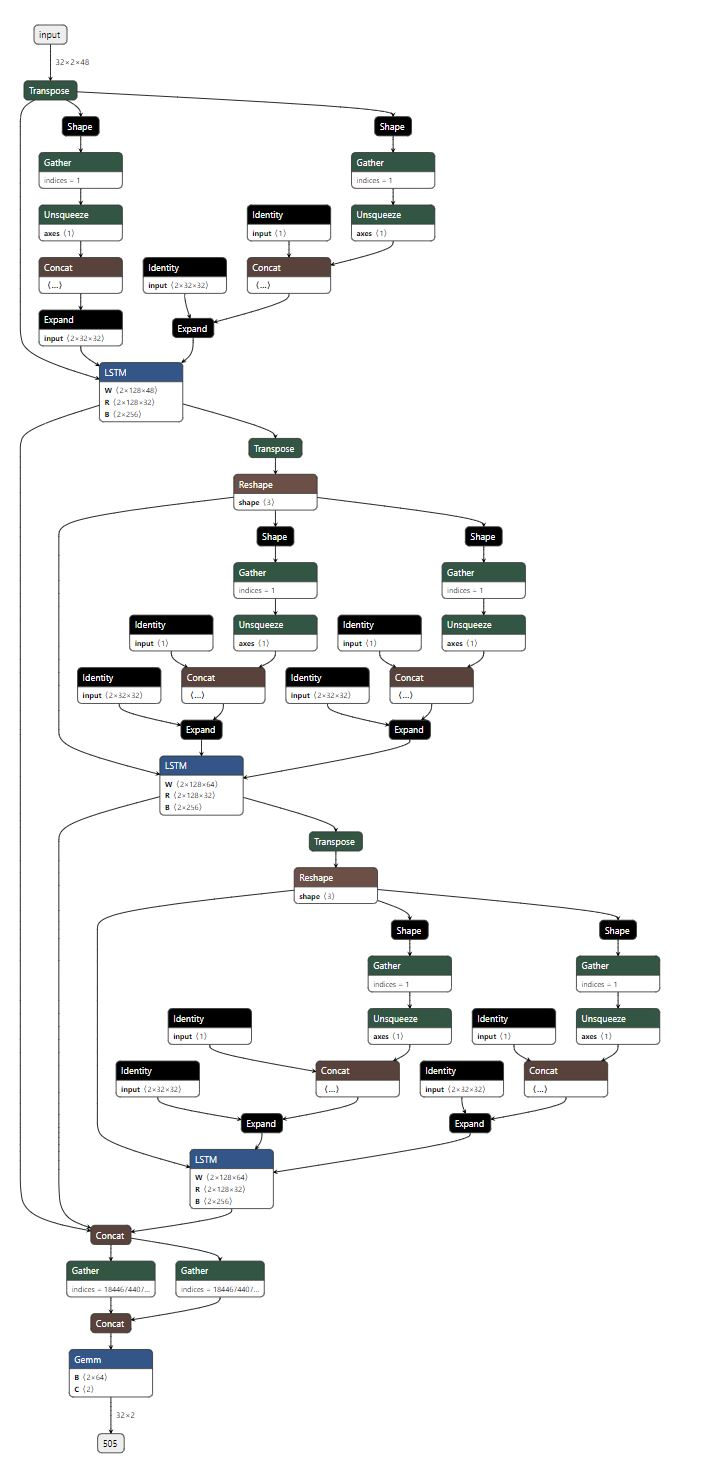